# Crevasse model over a parameter space
This note book looks in detail at individual solutions.  Another notebook looks at ensembles of solutions over different parts of the parameter space.

In [5]:
# The following few lines of code are unethical and shouldn't be used every again. But they work.
# import os
# os.environ['PATH'] = "/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:" + os.environ['PATH']
# print(os.environ['PATH'])

# from dolfin import *
# from mshr import *
import matplotlib.pyplot as plt
# %matplotlib notebook
from time import perf_counter
import numpy as np
import pickle
import scipy.integrate as integrate
import scipy.special as special
from os import path
import multiprocessing
from functools import partial
# import crevasse as c # main module for this project
# from importlib import reload
from scipy.optimize import fminbound
# reload(c)
# print (dolfin.__version__)

## Define baseline parameters

In [6]:
# Geometry: domain width, domain height,  crevasse location, crevasse width, crevasse height
geom = {'W':60000,'H':300,'Lc':15, 'Wc':1, 'Hc': 5}
    
# Materials: Youngs modulus, poisson ratio, ice density, water density, gravity
mats = {'E':1e10, 'nu':0.3, 'rho':910, 'rhow':1024, 'g':9.81}

# Analytical solutions

In [7]:
Lcs = np.logspace(np.log10(5),np.log10(50e3),50)
r = mats['rho']/mats['rhow']

D = mats['E']/(1-mats['nu']**2) * geom['H']**3 / 12
flexural_gravity_wavelength = 2*np.pi*(D/(mats['rhow']*mats['g']))**(1/4)
haf = geom['H'] - mats['rho']/mats['rhow'] * geom['H']

# Surface Crevasse
def f(y):
    gamma = y/geom['Hc']
    lambd = geom['Hc']/geom['H']
    val =  3.52*(1-gamma)/(1-lambd)**(3/2)
    val += - (4.35-5.28*gamma)/(1-lambd)**(1/2)
    val += ( (1.30 - 0.3*gamma**(3/2)) / (1-gamma**2)**(1/2) + 0.83 - 1.76*gamma) * (1 - (1-gamma)*lambd)
    return val
dK = integrate.quad(f, 0, geom['Hc'])
K_crack_face_loading_surface = 2*mats['rho']*mats['g']/np.sqrt(np.pi*geom['Hc']) * dK[0]

sig0 = mats['rho']*mats['g']*geom['H'] / 2 *(1-mats['rho']/mats['rhow'])
KI_analytical = 1.12 * sig0 * np.sqrt(np.pi * geom['Hc'])
KI_analytical += K_crack_face_loading_surface

lam = (4*D/(mats['rhow']*mats['g']))**(1/4)
m0 = mats['rho']*mats['g']*geom['H']**3 / 12 * (3*r - 2*r**2 - 1)
II = geom['H']**3 / 12
M_flex = m0 * np.exp(-Lcs/lam)*(np.cos(Lcs/lam) + np.sin(Lcs/lam))
sig_flex = M_flex * geom['H']/2 / II 
KI_analytical_bending = KI_analytical/1e6 + 1.12 * (sig_flex) * np.sqrt(np.pi * geom['Hc']) / 1e6



# Bottom Crevasse
def f_bot(y):
    Hw = mats['rho']/mats['rhow'] * geom['H']
    sig = lambda y: mats['rhow']*mats['g']*(Hw-y) - mats['rho']*mats['g']*(geom['H']-y)
    gamma = y/geom['Hc']
    lambd = geom['Hc']/geom['H']
    kernel =  3.52*(1-gamma)/(1-lambd)**(3/2)
    kernel += - (4.35-5.28*gamma)/(1-lambd)**(1/2)
    kernel += ( (1.30 - 0.3*gamma**(3/2)) / (1-gamma**2)**(1/2) + 0.83 - 1.76*gamma) * (1 - (1-gamma)*lambd)
    val = sig(y) * kernel
    return val
dK_bot = integrate.quad(f_bot, 0, geom['Hc'])
K_crack_face_loading_bottom  =  2/np.sqrt(np.pi*geom['Hc']) * dK_bot[0]
KI_analytical_bottom = KI_analytical - K_crack_face_loading_surface
KI_analytical_bending_bottom = KI_analytical_bottom/1e6 - 1.12 * (sig_flex) * np.sqrt(np.pi * geom['Hc']) / 1e6

# Calculate surface and bottom crevasse sifs for a range of locations
Or, if this has already been done, just load them from a file instead.

In [8]:
run_names = ('bottom','surface')

for this_run in run_names:

    filename = '%s-crevasse-sifs.pkl'%this_run
    
    if path.exists(filename):
        print('The simulation "%s" has already been run and saved. \n\
        To be safe, rename this file if you want to re-run.'%this_run)

    else:
        KIs = []
        KIIs = []

        g = geom

        t1_start = perf_counter() 
        for Lci in Lcs:
            g['Lc']=Lci
            these_Ks = c.sif(g,mats,verbose=False,loc='bottom')
            KIs.append(these_Ks[0])
            KIIs.append(these_Ks[1])
        t1_stop = perf_counter() 
        print("Elapsed time during the whole program in seconds:", t1_stop-t1_start)

        KIs = np.array(KIs)
        KIIs = np.array(KIIs)

        sifs = {'KI':KIs, 'KII':KIIs}

        with open(filename, 'wb') as f:
            pickle.dump(sifs, f)

The simulation "bottom" has already been run and saved. 
        To be safe, rename this file if you want to re-run.
The simulation "surface" has already been run and saved. 
        To be safe, rename this file if you want to re-run.


# Plot SIFs as a function of distance from the ice front

Text(0.5, 1.0, 'B. Near-front bottom crevasse')

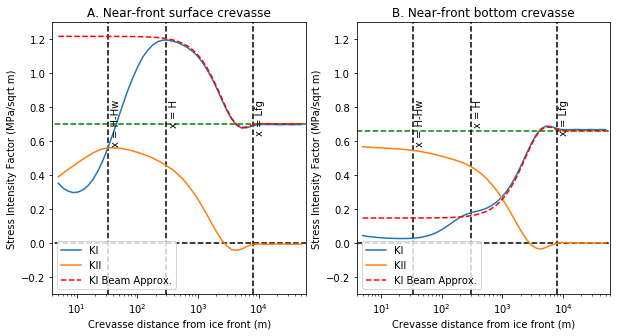

In [48]:
with open('surface-crevasse-sifs.pkl', 'rb') as f:
    surface_sifs = pickle.load(f)
with open('bottom-crevasse-sifs.pkl', 'rb') as f:
    bottom_sifs = pickle.load(f)

ymax = 1.3
ymin = -0.3

fig=plt.subplots(1,2,figsize=(10,5))
ax=plt.subplot(1,2,1)
plt.plot([0,100e3],KI_analytical*np.ones(2)/1e6,'--g')
plt.plot([0,100e3],[0,0],'--k')
plt.plot(geom['H']*np.ones(2),[ymin, ymax],'--k')
plt.plot(flexural_gravity_wavelength*np.ones(2),[ymin, ymax],'--k')
plt.plot(haf*np.ones(2),[ymin, ymax],'--k')
plt.plot(Lcs,surface_sifs['KI']/1e6,'-',label='KI')
plt.plot(Lcs,surface_sifs['KII']/1e6,'-',label='KII')
plt.plot(Lcs,KI_analytical_bending,'--r',label='KI Beam Approx.')
ax.set_ylim([ymin, ymax])
ax.set_xlim([4,60e3])
plt.legend(loc='lower left')
plt.xscale('log')

ax.text(geom['H']*1.1, 0.8, 'x = H', rotation=90)
ax.text(haf*1.1, 0.8, 'x = H-Hw', rotation=90)
ax.text(flexural_gravity_wavelength*1.1, 0.8, 'x = Lfg', rotation=90)

plt.xlabel('Crevasse distance from ice front (m)')
plt.ylabel('Stress Intensity Factor (MPa/sqrt m)')
plt.title('A. Near-front surface crevasse')

ax=plt.subplot(1,2,2)
plt.plot([0,100e3],KI_analytical_bottom*np.ones(2)/1e6,'--g')
plt.plot([0,100e3],[0,0],'--k')
plt.plot(geom['H']*np.ones(2),[ymin, ymax],'--k')
plt.plot(flexural_gravity_wavelength*np.ones(2),[ymin, ymax],'--k')
plt.plot(haf*np.ones(2),[ymin, ymax],'--k')
plt.plot(Lcs,bottom_sifs['KI']/1e6,'-',label='KI')
plt.plot(Lcs,bottom_sifs['KII']/1e6,'-',label='KII')
plt.plot(Lcs,KI_analytical_bending_bottom,'--r',label='KI Beam Approx.')
ax.set_ylim([ymin, ymax])
ax.set_xlim([4,60e3])
plt.legend(loc='lower left')
plt.xscale('log')
ax.text(geom['H']*1.1, 0.8, 'x = H', rotation=90)
ax.text(haf*1.1, 0.8, 'x = H-Hw', rotation=90)
ax.text(flexural_gravity_wavelength*1.1, 0.8, 'x = Lfg', rotation=90)
plt.xlabel('Crevasse distance from ice front (m)')
plt.ylabel('Stress Intensity Factor (MPa/sqrt m)')
plt.title('B. Near-front bottom crevasse')

# plt.savefig('figures/sif-variation-in-x.eps', format='eps')

# Calculate surface and bottom crevasse SIFs with swell

In [39]:
# The code to calculate swell sifs has been moved to run_crevasse_simulations.py

with open('swell-sifs-high-res-linear.pkl', 'rb') as f:
    output = pickle.load(f)

labels=('Surface KI','Surface KII','Basal KI','Basal KII')

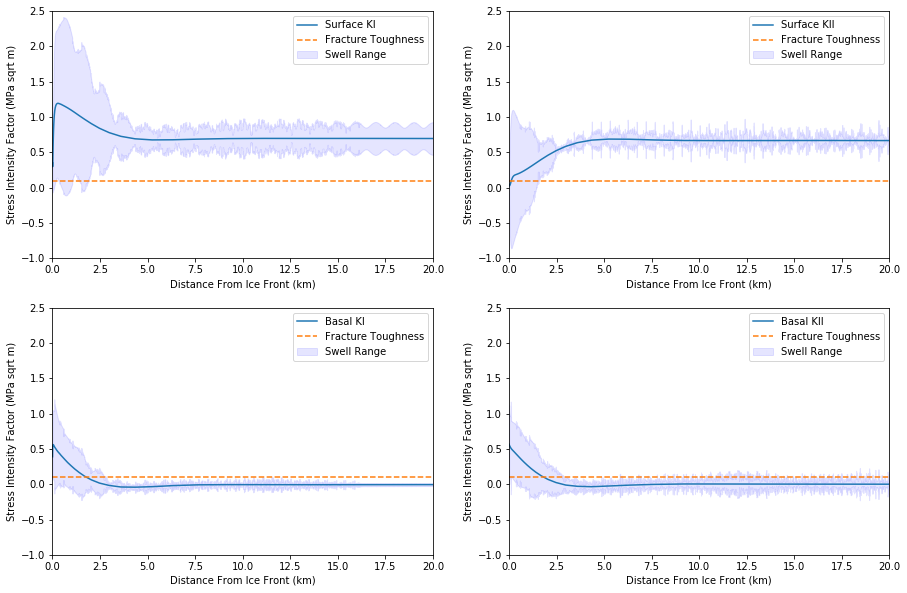

In [47]:
Lcs_swell = np.linspace(10,3*flexural_gravity_wavelength,10000)
    
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10))

for i,this_ax in enumerate((ax1,ax2,ax3,ax4)):

    if i==0:
        sif_no_swell = surface_sifs['KI']/1e6
    elif i ==1:
        sif_no_swell = bottom_sifs['KI']/1e6
    if i==2:
        sif_no_swell = surface_sifs['KII']/1e6
    elif i ==3:
        sif_no_swell = bottom_sifs['KII']/1e6
    sif_no_swell_interp = np.interp(Lcs_swell,Lcs,sif_no_swell)
    swell_min = np.array(output[i])[:,1]/1e6
    swell_max = 2*sif_no_swell_interp-np.array(output[i])[:,1]/1e6
    this_ax.fill_between(Lcs_swell/1e3, swell_max, swell_min, color="blue", alpha=0.1,label='Swell Range')
    this_ax.plot(Lcs/1e3,sif_no_swell,label=labels[i])
    this_ax.plot((0,20),(0.1,0.1),'--',label='Fracture Toughness')
    this_ax.set_xlim([0e3,20])
    this_ax.set_ylim([-1,2.5])
    this_ax.set_ylabel('Stress Intensity Factor (MPa sqrt m)')
    this_ax.set_xlabel('Distance From Ice Front (km)')
    this_ax.legend()
    # Plot the phase of maximum amplitude:
#     ax2 = this_ax.twinx()
#     ax2.plot(Lcs_swell,np.unwrap(np.array(output[i])[:,0]),'.r')

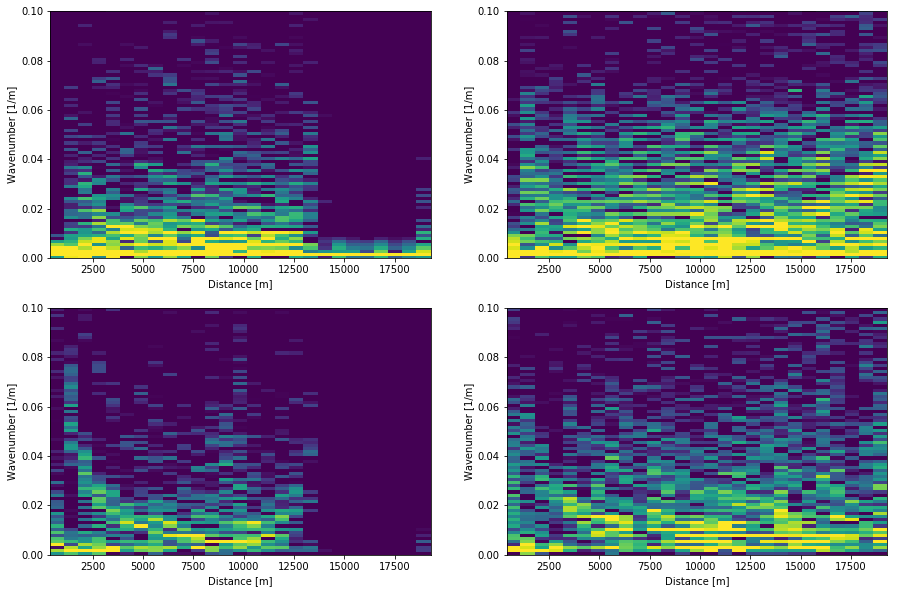

In [134]:
from scipy.signal import spectrogram

fs = 0.5

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10))

for i,this_ax in enumerate((ax1,ax2,ax3,ax4)):
    
    x = np.array(output[i])[:,1]/1e6
    f, t, Sxx = spectrogram(x, fs,nperseg=400)
    this_ax.pcolormesh(t, f, np.log10(Sxx),vmin=-3,vmax=-1)
    this_ax.set_ylim((0,0.1))
    this_ax.set_ylabel('Wavenumber [1/m]')
    this_ax.set_xlabel('Distance [m]')
#     this_ax.colorbar(c) 